# *0.* Preparation

In [1]:
!pip uninstall -y tensorflow && pip install tensorflow-gpu==1.15.0 Keras==2.0.8

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 411.5MB 42kB/s 
     |████████████████████████████████| 276kB 30.7MB/s 
     |████████████████████████████████| 3.8MB 40.9MB/s 
     |████████████████████████████████| 512kB 38.1MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=d0b17d46f6508d6949452c5b0c9084b4c17a870a78bb2bcda52f6172d7a1f121
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2

In [2]:
from google.colab import drive
try:
  drive.mount('./gdrive')
except ValueError:
  pass

Mounted at ./gdrive


In [3]:
cd "/content/gdrive/Shared drives/PrussianBlue/"

/content/gdrive/Shared drives/PrussianBlue


In [4]:
import os
import sys
default_DIR = os.getcwd()
sys.path.append(os.path.join(default_DIR, 'Model','Mask_RCNN'))  # To find local version of the library

---

# *1.* Initial Setting

In [5]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf 
import glob
import shutil
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve,auc,precision_recall_curve,auc
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
class DetectorConfigVer2(Config):
    NAME = "PrussianBlue"
    IMAGES_PER_GPU = 3
    NUM_CLASSES = 1 + 1  # Background + nucleus
    STEPS_PER_EPOCH = 213
    VALIDATION_STEPS = 5
    BACKBONE = "resnet101"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000
    LEARNING_RATE = 0.0005
    RPN_NMS_THRESHOLD = 0.9
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])
    WEIGHT_DECAY = 0.001
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    TRAIN_ROIS_PER_IMAGE = 128
    MAX_GT_INSTANCES = 200
    DETECTION_MAX_INSTANCES = 400

In [7]:
class InferenceConfig(DetectorConfigVer2):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
inference_config = InferenceConfig()

In [8]:
def union2d(arr1, arr2):
  arr1 = np.array(arr1)
  arr2 = np.array(arr2)
  loc = arr2 == 0
  arr2[loc] = arr1[loc]
  return arr2
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def rle_decode(mask_rle, shape=(1000,1000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [9]:
inputFolder = os.path.join(default_DIR, 'Input','PB') # Set the Folder where you want to load or save from current folder.  ex) For_Prussianblue/input/apple  => os.path.join(default_DIR, 'input','apple')
outputFolder = os.path.join(default_DIR, 'Output','PB')

## (Optional) Make a Mask Table
**Requirement**<br>
>[ImageName] : Folder  
- Each Mask : Each mask in the image
- RGB Data : A image based on RGB

In [10]:
Encoded = True # If you already encoded masks, the value is True

In [11]:
encodeFolder = os.path.join(default_DIR, 'Encode','PB')
encodeList = os.listdir(encodeFolder)

In [12]:
if not Encoded: 
  dataset = pd.DataFrame(columns=['ImageId','EncodedPixels'])
  for data in tqdm(encodeList):
      imageName = data + '.tiff'
      imageFile = os.path.join(encodeFolder,data,"RGB Data",imageName)
      maskFolder = os.path.join(encodeFolder,data,"Each Mask/")
      shutil.copy(imageFile, inputFolder)
      for mdata in os.listdir(maskFolder):
          end = dataset.shape[0]
          test = cv2.imread(maskFolder+mdata,cv2.IMREAD_GRAYSCALE)
          dataset.loc[end,'ImageId'] = imageName
          dataset.loc[end,'EncodedPixels'] = rle_encode(test)
  dataset.to_csv('EncodedMasks.csv')

In [13]:
masks = pd.read_csv('EncodedMasks.csv',index_col=0)
masks['simpleId'] = ['_'.join(x) for x in masks['ImageId'].str.split('_').str[0:2]]

#*2.* Predict

In [14]:
model4PB = f"{default_DIR}/Model/mask_rcnn_prussianblue_0031.h5"

In [15]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Recreate the model in inference mode
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode='inference', 
                            config=inference_config,
                            model_dir='./Model')

# Load trained weights (fill in path to trained weights here)
assert model4PB != "", "Provide path to trained weights"
print("Loading weights from ", model4PB)
model.load_weights(model4PB, by_name=True)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/gdrive/Shared drives/PrussianBlue/Model/mask_rcnn_prussianblue_0031.h5







In [21]:
def visualize_test(path, model, all_masks = False):
  plotsize = 3
  image_names = os.listdir(path)
  for idx, img in tqdm(enumerate(image_names)):
    image_id = img
    img_path = os.path.join(path,img)
    ds = load_img(img_path)
    image = img_to_array(ds)
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    if isinstance(all_masks, pd.DataFrame):
      plotsize = 5
      y_true = np.zeros((1000,1000))
      for img in all_masks[all_masks['ImageId'] == image_id]['EncodedPixels']: 
        y = rle_decode(img)
        y_true = union2d(y_true, y)
    results = model.detect([image])
    r = results[0]
    image = np.array(image,np.int32)
    y_pred = r['masks'].max(-1)
    fig, axarr = plt.subplots(1, plotsize, figsize=(20, 40))
    axarr[0].set_title(image_id)
    axarr[0].imshow(image)
    axarr[1].set_title(f"{len(r['rois'])} masks predicted")
    axarr[1].imshow(y_pred)
    axarr[2].set_title('contuor version')
    axarr[2].imshow(image)
    axarr[2].imshow(y_pred, alpha=0.4)
    if isinstance(all_masks, pd.DataFrame):
      axarr[3].set_title('True value')
      axarr[3].imshow(y_true)
      axarr[4].set_title('True contuor value')
      axarr[4].imshow(image)
      axarr[4].imshow(y_true, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()
    coordinate = np.array(y_pred)
    coordinates = pd.DataFrame(coordinate) # equivalent to checking a == True
    coordinates.to_csv(f'./Output/prob_pixelwise/{image_id}.txt', index=False, header=None, sep="\t")
  print('\nDone')

In [17]:
inputFolderApple = '/content/gdrive/Shared drives/PrussianBlue/Input/Apple/'

In [18]:
input_names_apple = os.listdir(inputFolderApple)

0it [00:00, ?it/s]

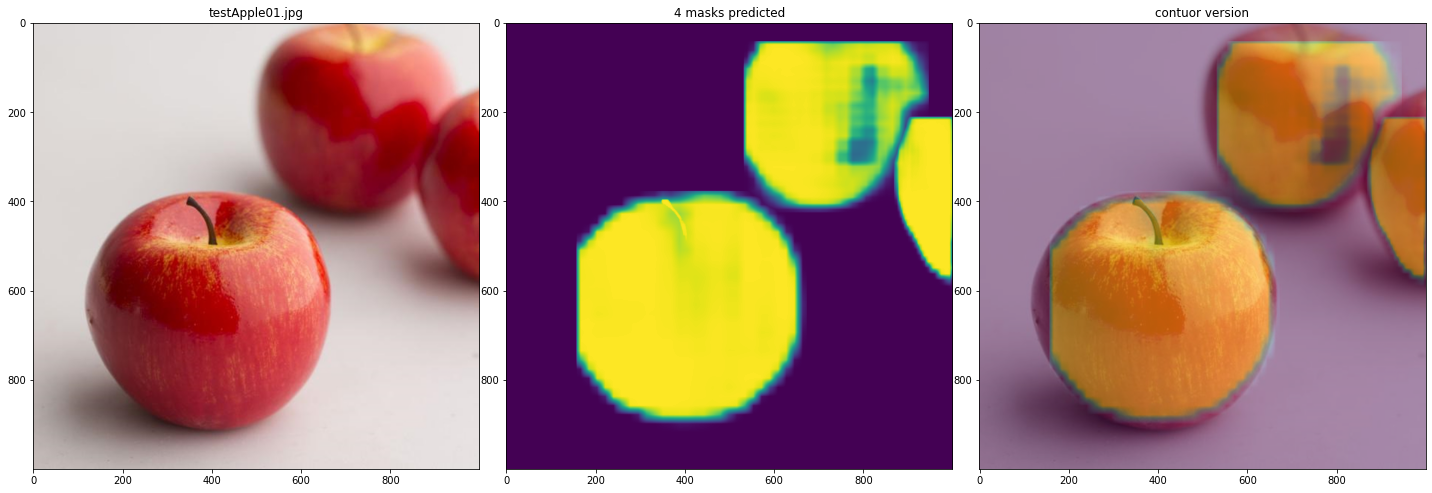

1it [00:11, 11.72s/it]

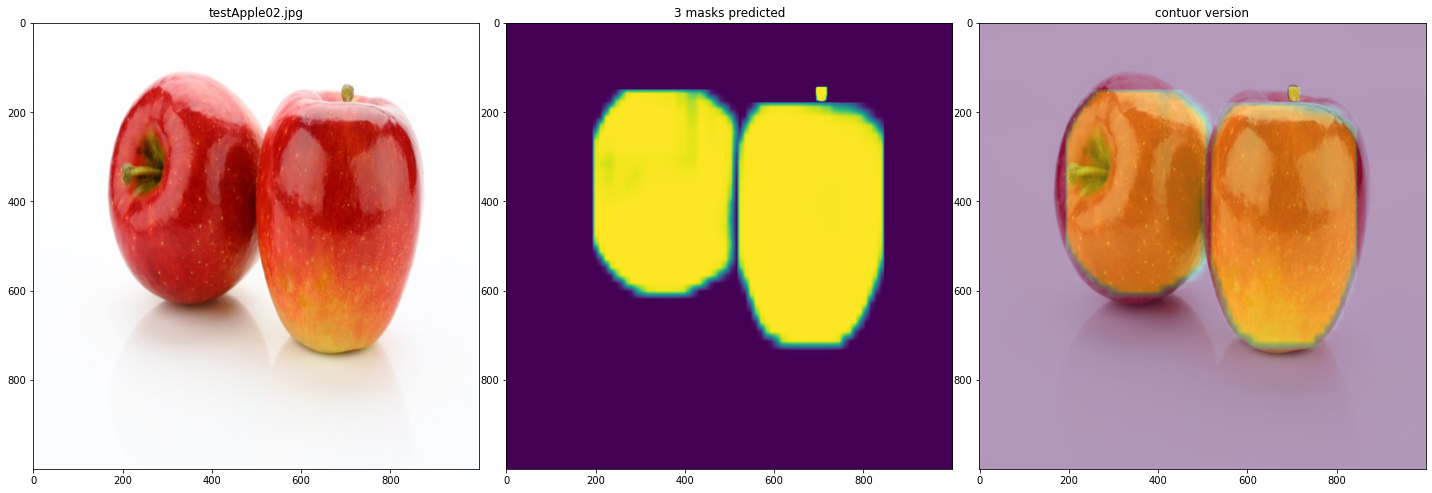

2it [00:13,  6.97s/it]


Done


In [19]:
visualize_test(inputFolderApple, model)

In [22]:
%%time
visualize_test(inputFolder, model, masks) # if you got a error, go to (Optional) Data Preprocessing part


0it [00:00, ?it/s]
1it [00:00,  1.55it/s]
2it [00:01,  1.59it/s]
3it [00:01,  1.63it/s]
4it [00:02,  1.51it/s]
5it [00:03,  1.64it/s]
6it [00:03,  1.60it/s]
7it [00:04,  1.63it/s]
8it [00:05,  1.28it/s]
9it [00:08,  1.50s/it]
10it [00:10,  1.49s/it]
11it [00:11,  1.55s/it]
12it [00:12,  1.41s/it]
13it [00:14,  1.44s/it]
14it [00:15,  1.39s/it]
15it [00:17,  1.41s/it]
16it [00:18,  1.33s/it]
17it [00:20,  1.64s/it]
18it [00:21,  1.49s/it]
19it [00:23,  1.59s/it]
20it [00:26,  2.03s/it]
21it [00:27,  1.65s/it]
22it [00:28,  1.48s/it]
23it [00:29,  1.33s/it]
24it [00:30,  1.21s/it]
25it [00:31,  1.13s/it]
26it [00:32,  1.20s/it]
27it [00:33,  1.20s/it]
28it [00:35,  1.20s/it]
29it [00:36,  1.25s/it]
30it [00:37,  1.29s/it]
31it [00:38,  1.15s/it]
32it [00:39,  1.15s/it]
33it [00:40,  1.12s/it]
34it [00:42,  1.14s/it]
35it [00:43,  1.13s/it]
36it [00:44,  1.17s/it]
37it [00:45,  1.20s/it]
38it [00:48,  1.67s/it]
39it [00:49,  1.49s/it]
40it [00:50,  1.39s/it]
41it [00:51,  1.31s/it]
42it 


Done
CPU times: user 46.3 s, sys: 33.5 s, total: 1min 19s
Wall time: 2min 7s
